📈 Previsão da Tendência do IBOVESPA: Um Modelo Preditivo em Python
Este notebook apresenta o desenvolvimento de um modelo preditivo para classificar a tendência (alta ou baixa) do índice IBOVESPA no dia seguinte, com base em dados históricos. O objetivo é criar um insumo para dashboards internos de analistas quantitativos.

1. Configuração Inicial e Importação de Bibliotecas
Primeiro, vamos importar todas as bibliotecas necessárias para a manipulação de dados, engenharia de atributos, modelagem e avaliação.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier # Escolha inicial para bom balanço
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Configurações de visualização para gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [68]:
df =pd.read_csv("Dados Históricos - Ibovespa.csv")

In [69]:
# Exibindo as 5 primeiras linhas e informações gerais
print("--- Primeiras 5 linhas do DataFrame ---")
df.head(5)


--- Primeiras 5 linhas do DataFrame ---


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,25.06.2025,135.803,137.163,137.163,135.565,"6,53M","-0,99%"
1,24.06.2025,137.165,136.552,138.156,136.254,"8,08B","0,45%"
2,23.06.2025,136.551,137.116,137.130,135.835,"7,73B","-0,41%"
3,20.06.2025,137.116,138.715,138.719,136.815,"11,29B","-1,15%"
4,18.06.2025,138.717,138.844,139.161,138.443,"8,32B","-0,09%"


In [70]:
print("\n--- Informações do DataFrame (tipos de dados, não-nulos) ---")
df.info()


--- Informações do DataFrame (tipos de dados, não-nulos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      499 non-null    object 
 1   Último    499 non-null    float64
 2   Abertura  499 non-null    float64
 3   Máxima    499 non-null    float64
 4   Mínima    499 non-null    float64
 5   Vol.      499 non-null    object 
 6   Var%      499 non-null    object 
dtypes: float64(4), object(3)
memory usage: 27.4+ KB


============================================================================================
-  Todos os dados estão como object (string), o que indica a necessidade de pré-processamento.
 

2.1 Limpeza e Pré-processamento dos Dados
Precisamos converter as colunas para os tipos de dados corretos e lidar com as inconsistências (vírgulas, notação de volume, formatos de data).

In [71]:
# Converter a coluna 'Data' para datetime64
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True, errors='coerce')

In [72]:
# Converter a coluna 'Vol.' para float64
# Substituir pontos por nada (milhar), e vírgulas por pontos (decimal)
# Limpar e converter a coluna 'vol_'
def convert_volume(vol_str):
    vol_str = vol_str.replace(',', '.')
    if 'B' in vol_str:
        return float(vol_str.replace('B', '')) * 1_000_000_000
    elif 'M' in vol_str:
        return float(vol_str.replace('M', '')) * 1_000_000
    return float(vol_str)

df['Vol.'] = df['Vol.'].apply(convert_volume)

In [73]:
# Converter a coluna 'Var%' para float64
# Remover o símbolo de porcentagem e converter
df['Var%'] = df['Var%'].str.replace('%', '', regex=False).str.replace(',', '.', regex=False)
df['Var%'] = pd.to_numeric(df['Var%'], errors='coerce')

In [74]:
# Ordenar os dados por data (muito importante para séries temporais)
df.sort_values(by='Data', inplace=True)
df.reset_index(drop=True, inplace=True)

In [75]:
print("--- DataFrame após limpeza e conversão de tipos ---")
print(df.head())
print("\n--- Informações do DataFrame após limpeza ---")
print(df.info())

--- DataFrame após limpeza e conversão de tipos ---
        Data   Último  Abertura   Máxima   Mínima        Vol.  Var%
0 2023-06-26  118.243   118.977  119.148  117.491  10460000.0 -0.62
1 2023-06-27  117.523   118.246  119.212  116.561  13080000.0 -0.61
2 2023-06-28  116.681   117.524  117.937  116.560  10650000.0 -0.72
3 2023-06-29  118.383   116.683  118.623  116.683  11060000.0  1.46
4 2023-06-30  118.087   118.388  119.447  118.087  13820000.0 -0.25

--- Informações do DataFrame após limpeza ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      499 non-null    datetime64[ns]
 1   Último    499 non-null    float64       
 2   Abertura  499 non-null    float64       
 3   Máxima    499 non-null    float64       
 4   Mínima    499 non-null    float64       
 5   Vol.      499 non-null    float64       
 6   Var%      499 no

2.2 Plot do preço de fechamento

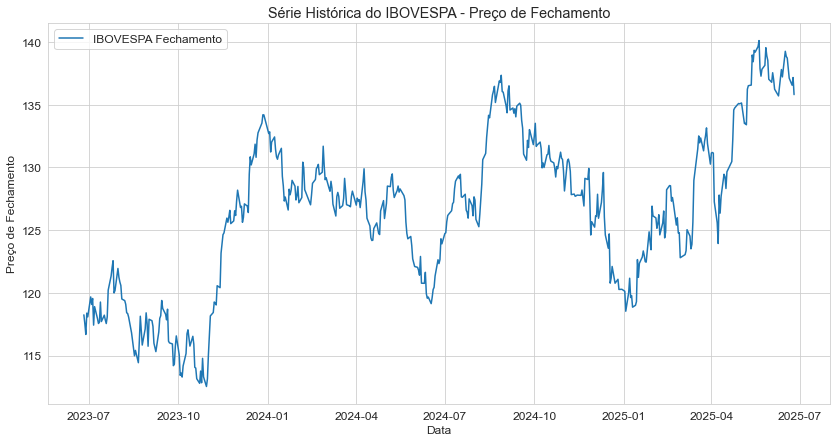

In [76]:
# Plot do preço de fechamento
plt.figure(figsize=(14, 7))
plt.plot(df['Data'], df['Último'], label='IBOVESPA Fechamento')
plt.title('Série Histórica do IBOVESPA - Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

3. Estratégia de Engenharia de Atributos. 
Aqui, vamos criar as features que o modelo usará para aprender os padrões. Incluiremos a variável alvo, valores defasados, médias móveis e outras métricas.